# Looking at Models to Predict Confirmed Cases and Deaths

Given my initial screw up using a linear model given that we can only predict on time, I will look at various time series models and train them here.

In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
train = pd.read_csv('../data/train.csv')
train.head()

,ID,Province_State,Date,Confirmed,Deaths,Recovered,Active,Incident_Rate,People_Tested,People_Hospitalized,Mortality_Rate,Testing_Rate,Hospitalization_Rate
0,0,Alabama,04-12-2020,3563,93,NaN,3470.0,75.988020,21583.0,437.0,2.610160,460.300152,12.264945
1,1,Alaska,04-12-2020,272,8,66.0,264.0,45.504049,8038.0,31.0,2.941176,1344.711576,11.397059
2,2,Arizona,04-12-2020,3542,115,NaN,3427.0,48.662422,42109.0,NaN,3.246753,578.522286,NaN
3,3,Arkansas,04-12-2020,1280,27,367.0,1253.0,49.439423,19722.0,130.0,2.109375,761.753354,10.156250
4,4,California,04-12-2020,22795,640,NaN,22155.0,58.137726,190328.0,5234.0,2.812020,485.423869,22.961176


In [3]:
train.dtypes

ID                        int64
Province_State           object
Date                     object
Confirmed                 int64
Deaths                    int64
Recovered               float64
Active                  float64
Incident_Rate           float64
People_Tested           float64
People_Hospitalized     float64
Mortality_Rate          float64
Testing_Rate            float64
Hospitalization_Rate    float64
dtype: object

In [4]:
train['Date'] = pd.to_datetime(train['Date'])

# Autoregressive Model

For an autoregressive model, we need the the future time step to be correlated with the current time step, so I need to check if that is indeed true for our covid19 data.

In [5]:
cali = train.loc[train['Province_State'] == 'Arizona']
cali.head()

,ID,Province_State,Date,Confirmed,Deaths,Recovered,Active,Incident_Rate,People_Tested,People_Hospitalized,Mortality_Rate,Testing_Rate,Hospitalization_Rate
2,2,Arizona,2020-04-12,3542,115,NaN,3427.0,48.662422,42109.0,NaN,3.246753,578.522286,NaN
52,52,Arizona,2020-04-13,3705,122,NaN,3583.0,50.901828,43347.0,525.0,3.292848,595.530778,14.170040
102,102,Arizona,2020-04-14,3809,131,249.0,3678.0,52.330651,44096.0,580.0,3.439223,605.821053,15.227094
152,152,Arizona,2020-04-15,3964,142,385.0,3822.0,54.460147,45310.0,590.0,3.582240,622.499817,14.883956
202,202,Arizona,2020-04-16,4237,150,460.0,4087.0,58.210808,47398.0,578.0,3.540241,651.186191,13.641728


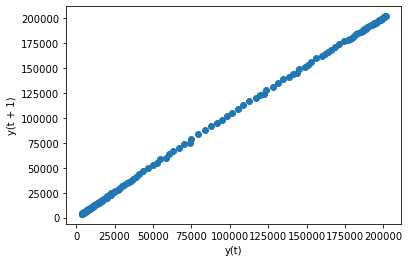

In [6]:
pd.plotting.lag_plot(cali['Confirmed'])

This looks very linear, so it seems promising to use an AR model

Please install the statsmodels package before you run this cell.

In [7]:
from statsmodels.tsa.ar_model import AutoReg

In [8]:
len(cali['Confirmed'])

142

In [9]:
#I will try and predict the last 7 days
cali_train = cali['Confirmed'].iloc[0:112]
cali_test = cali['Confirmed'].iloc[112:142]

In [10]:
model = AutoReg(np.log(cali_train).to_numpy(), lags=1, trend = 'ct')
model_fit = model.fit()
predicted_confirmed = model_fit.predict(start=112, end=141, dynamic=False)
predicted_confirmed

array([12.10683023, 12.12936709, 12.15152074, 12.17328494, 12.19465334,
       12.21561949, 12.23617683, 12.25631872, 12.27603836, 12.2953289 ,
       12.31418332, 12.33259454, 12.35055531, 12.36805831, 12.38509608,
       12.40166103, 12.41774545, 12.43334153, 12.4484413 , 12.46303667,
       12.47711942, 12.49068121, 12.50371353, 12.51620777, 12.52815516,
       12.53954678, 12.55037358, 12.56062636, 12.57029576, 12.57937227])

In [11]:
len(cali_test)

30

In [12]:
len(predicted_confirmed)

30

In [13]:
#Plotting the two variables with their dates
dates = cali['Date'].iloc[112:142].to_numpy()
d1 = {'Date' : dates, 'Confirmed': cali_test.to_numpy()}
d2 = {'Date' : dates, 'Confirmed': np.exp(predicted_confirmed)}
actual = pd.DataFrame(d1)
predicted = pd.DataFrame(d2)

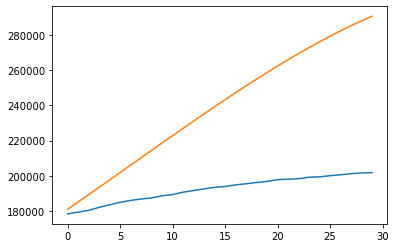

In [14]:
plt.plot(actual['Confirmed'])
plt.plot(predicted['Confirmed'])

We can kind of see the predicted and actual diverge as time goes on, since we are predicting for only 30 days it isn't too bad as you will see below

In [15]:
def MAPE(pred, actual):
    assert len(pred) == len(actual)
    res = 0
    for i, val in enumerate(pred):
        diff = np.abs(val - actual[i])
        diff = diff / np.abs(actual[i])
        res += diff
    return res/len(pred) * 100

In [16]:
MAPE(predicted['Confirmed'], actual['Confirmed'])

23.891354502136686

# Lets try it for each state and see the error for each state

In [17]:
def train_confirmed_toy():
    total_err = 0
    for state in np.unique(train['Province_State']):
        split = train.loc[train['Province_State'] == state]
        split_train = split['Confirmed'].iloc[0:112].to_numpy()
        split_test = split['Confirmed'].iloc[112:142].to_numpy()
        model = AutoReg(split_train, lags = 3)
        model_fit = model.fit()
        predicted_cases = model_fit.predict(start = 112, end = 141, dynamic = False)
        mape = MAPE(predicted_cases, split_test)
        print(str(state) + ": " + str(mape))
        total_err += len(predicted_cases) * mape
    return total_err/(30*50)

total_mape = train_confirmed_toy()

Alabama: 19.551293098362354
Alaska: 45.44252197612227
Arizona: 24.92196774155464
Arkansas: 13.149974577519757
California: 14.337610791129205
Colorado: 0.9404320545032433
Connecticut: 1.8838237807735094
Delaware: 2.4930531395624835
Florida: 22.803449366856874
Georgia: 16.977831767216742
Hawaii: 9.574341188706113
Idaho: 21.85034009653321
Illinois: 5.554983323593452
Indiana: 3.113026237565192
Iowa: 1.6678907264210026
Kansas: 0.8089730487359398
Kentucky: 6.196334905585877
Louisiana: 16.345917444962673
Maine: 2.5497098022031803
Maryland: 0.6504682195738026
Massachusetts: 3.4002650892105786
Michigan: 3.733343180207894
Minnesota: 0.37571527986869485
Mississippi: 20.598127868977897
Missouri: 22.30827703896972
Montana: 39.50577431948338
Nebraska: 3.3636438474372516
Nevada: 23.904404983254842
New Hampshire: 0.8069224522679712
New Jersey: 2.5661272302711655
New Mexico: 9.479962534072655
New York: 3.0066468133381807
North Carolina: 12.767525577783543
North Dakota: 3.0417381465552227
Ohio: 5.506680

In [18]:
total_mape

11.31460870901712

### We see that differencing the data is important, lets focus on california

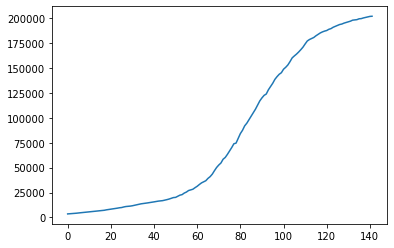

In [19]:
plt.plot(cali['Confirmed'].values)

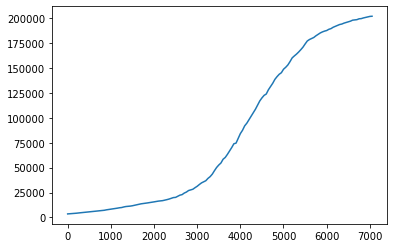

In [20]:
current_cases = cali['Confirmed']
plt.plot(current_cases)

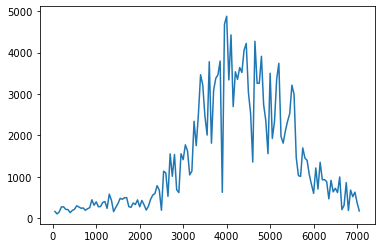

In [21]:
plt.plot(current_cases.diff())

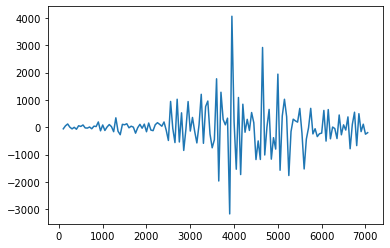

In [22]:
plt.plot(current_cases.diff().diff())

So a difference order of two looks the most promising

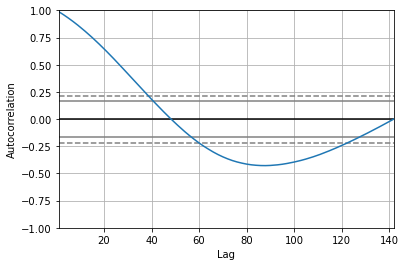

In [23]:
pd.plotting.autocorrelation_plot(current_cases)

There seems to be positive correlation for the first 50 lags

In [24]:
import statsmodels.api as sm

In [25]:
cali_train = cali['Confirmed'].iloc[:112]
cali_test = cali['Confirmed'].iloc[112:]


/home/lala/.local/share/miniconda/envs/covid19/lib/python3.7/site-packages/statsmodels/regression/linear_model.py:1406: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


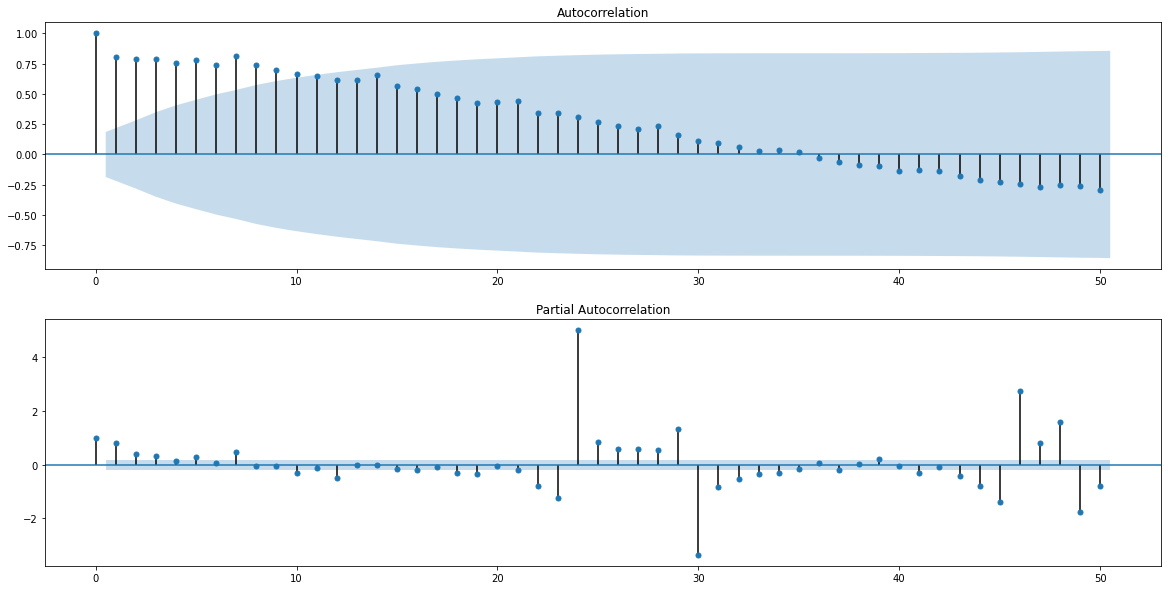

In [26]:
fig,ax = plt.subplots(2,1,figsize=(20,10))
fig = sm.graphics.tsa.plot_acf(cali_train.diff().dropna(), lags=50, ax=ax[0])
fig = sm.graphics.tsa.plot_pacf(cali_train.diff().dropna(), lags=50, ax=ax[1])
plt.show()

In [27]:
resDiff = sm.tsa.arma_order_select_ic(cali_train, max_ar=7, max_ma=7, ic='bic', trend='c')
print('ARMA(p,q) =',resDiff['bic_min_order'],'is the best.')

/home/lala/.local/share/miniconda/envs/covid19/lib/python3.7/site-packages/statsmodels/base/model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/home/lala/.local/share/miniconda/envs/covid19/lib/python3.7/site-packages/statsmodels/base/model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/home/lala/.local/share/miniconda/envs/covid19/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/lala/.local/share/miniconda/envs/covid19/lib/python3.7/site-packages/statsmodels/base/model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/home/lala/.local/share/miniconda/envs/covid19/lib/python3.7/site-packages/st

/home/lala/.local/share/miniconda/envs/covid19/lib/python3.7/site-packages/statsmodels/base/model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/home/lala/.local/share/miniconda/envs/covid19/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/lala/.local/share/miniconda/envs/covid19/lib/python3.7/site-packages/statsmodels/base/model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/home/lala/.local/share/miniconda/envs/covid19/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/lala/.local/share/miniconda/envs/covid19/lib/python3.7/site-

/home/lala/.local/share/miniconda/envs/covid19/lib/python3.7/site-packages/statsmodels/base/model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/home/lala/.local/share/miniconda/envs/covid19/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/lala/.local/share/miniconda/envs/covid19/lib/python3.7/site-packages/statsmodels/base/model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/home/lala/.local/share/miniconda/envs/covid19/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/lala/.local/share/miniconda/envs/covid19/lib/python3.7/site-

ARMA(p,q) = (3, 2) is the best.


/home/lala/.local/share/miniconda/envs/covid19/lib/python3.7/site-packages/statsmodels/base/model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/home/lala/.local/share/miniconda/envs/covid19/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Ok so we have p = 1, q = 1 so ARIMA(4, 1, 1)

In [28]:
from statsmodels.tsa.arima_model import ARIMA

In [29]:
arima = sm.tsa.statespace.SARIMAX(cali_train.values,order=(4,1,1),seasonal_order=(0,0,0,0),
                                 enforce_stationarity=False, enforce_invertibility=False,).fit()
print(arima.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  112
Model:               SARIMAX(4, 1, 1)   Log Likelihood                -849.142
Date:                Sun, 29 Nov 2020   AIC                           1710.285
Time:                        17:24:36   BIC                           1726.322
Sample:                             0   HQIC                          1716.786
                                - 112                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8671      0.181      4.784      0.000       0.512       1.222
ar.L2          0.0069      0.100      0.069      0.945      -0.190       0.204
ar.L3          0.0843      0.150      0.563      0.5

In [30]:
predicted = arima.forecast(30)

In [31]:
predicted

array([179665.90788701, 182388.42367478, 185173.84662806, 187976.01159868,
       190782.35156262, 193600.54149041, 196433.46178244, 199280.39134536,
       202140.77000226, 205014.71770305, 207902.41177602, 210803.92501939,
       213719.30506102, 216648.61440696, 219591.92222333, 222549.29642286,
       225520.80392637, 228506.51206051, 231506.48871033, 234520.80210421,
       237549.52075879, 240592.71350958, 243650.44952629, 246722.79831139,
       249809.82969894, 252911.61385625, 256028.22128601, 259159.72282789,
       262306.18966014, 265467.69330114])

In [32]:
cali['Confirmed'].values[112:]

array([178467, 179497, 180505, 182203, 183656, 185053, 186107, 186923,
       187523, 188737, 189443, 190794, 191721, 192654, 193537, 194005,
       194920, 195557, 196280, 196899, 197895, 198103, 198414, 199273,
       199459, 200139, 200658, 201287, 201661, 201835])

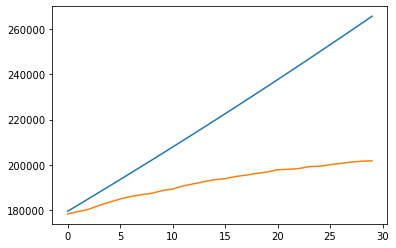

In [33]:
plt.plot(predicted)
plt.plot(cali['Confirmed'].values[112:])

In [34]:
MAPE(predicted, cali['Confirmed'].values[112:])

14.823640040176167

Welp, still not that great, the constant linear prediciton really doesn't reflect how the cases evolve (plateauing and stuff)